In [3]:
import pandas as pd 
import glob
import sqlite3

In [6]:
to_run = glob.glob('../data/diffengine-diffs/spark-output/*')

In [4]:
all_added_sents = []

In [5]:
conn=sqlite3.connect(to_run[3])

In [13]:
ls cache/

2021-01-07__ap-article-diffs-sample.pkl
2021-01-07__ap-article-diffs.pkl
all-short-documents-eval-processed.pkl
all_del_df.csv
all_new_df.csv
all_num_sents_df.csv
all_perc_new_df.csv
raw-counts.csv
sample-ids-sentence-stats-df.csv
sample-ids-word-stats-df.csv
wp-sentence-diffs.csv


In [16]:
for f in to_run:
    print(f)
    conn = sqlite3.connect(f)
    source = f.split('/')[-1].split('-')[0]
    sent_count = pd.read_sql('''SELECT COUNT(*) as c from split_sentences''', con=conn)['c'].iloc[0]
    print('Total sents: %s' % sent_count)
    for file_idx, start_idx in enumerate(range(0, sent_count, 5_000_000)):
        print(file_idx)
        sents = pd.read_sql('select * from split_sentences LIMIT 5000000 OFFSET %s' % start_idx, con=conn)
        sents.to_pickle('cache/%s-sents__%s.pkl' % (source, file_idx))

../data/diffengine-diffs/spark-output/wp-matched-sentences.db
Total sents: 3200896
0
../data/diffengine-diffs/spark-output/independent-matched-sentences.db
Total sents: 3484388
0
../data/diffengine-diffs/spark-output/reuters-matched-sentences.db
Total sents: 3626376
0
../data/diffengine-diffs/spark-output/guardian-matched-sentences.db
Total sents: 32780166
0
1
2
3
4
5
6
../data/diffengine-diffs/spark-output/nyt-matched-sentences.db
Total sents: 20561360
0
1
2
3
4
../data/diffengine-diffs/spark-output/bbc-2-matched-sentences.db
Total sents: 15724670
0
1
2
3
../data/diffengine-diffs/spark-output/ap-matched-sentences.db
Total sents: 2385991
0


In [ ]:
bbc_sents = pd.read_sql('select * from split_sentences', con=conn)

In [8]:
all_added_sents = []
for f in to_run:
    print(f)
    if '.gz' in f:
        ! gunzip $f
    f = f.replace('.gz', '')
    conn = sqlite3.connect(f)
#     add_info = pd.read_sql('''
#         with is_added as (
#                 SELECT entry_id, 
#                 version_y as version, 
#                 sent_idx_y as sent_idx, 
#                 0 as is_deleted,
#                 CAST((sent_idx_x IS NULL) AS INT) AS is_added
#             FROM matched_sentences
#                 WHERE is_added = 1
#         )
#         SELECT s.* from split_sentences s 
#         JOIN is_added a
#         ON a.entry_id = s.entry_id AND a.version = s.version AND a.sent_idx = s.sent_idx
#     ''', con=conn)
    add_info = pd.read_sql('''
        SELECT entry_id, 
        version_y as version, 
        sent_idx_y as sent_idx, 
        CAST((sent_idx_x IS NULL) AS INT) AS is_added
    FROM matched_sentences
        WHERE is_added = 1
''', con=conn)
    add_info['source'] = f.split('/')[-1].split('-')[0]
    all_added_sents.append(add_info)

../data/diffengine-diffs/spark-output/wp-matched-sentences.db
../data/diffengine-diffs/spark-output/independent-matched-sentences.db
../data/diffengine-diffs/spark-output/reuters-matched-sentences.db
../data/diffengine-diffs/spark-output/guardian-matched-sentences.db
../data/diffengine-diffs/spark-output/nyt-matched-sentences.db
../data/diffengine-diffs/spark-output/bbc-2-matched-sentences.db
../data/diffengine-diffs/spark-output/ap-matched-sentences.db


In [9]:
all_added_idx_df = pd.concat(all_added_sents)

In [10]:
from tqdm.auto import tqdm

In [11]:
all_sents = []
for sent_pkl in tqdm(glob.glob('cache/*sents__*.pkl')):
    sents_df = pd.read_pickle(sent_pkl)
    source = sent_pkl.split('/')[1].split('-')[0]
    source_added_idx = all_added_idx_df.loc[lambda df: df['source'] == source]
    source_sents = (
        source_added_idx
            .merge(sents_df,
                right_on=['entry_id', 'version', 'sent_idx'],
                left_on=['entry_id', 'version', 'sent_idx']
            )
    )
    all_sents.append(source_sents)

  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
all_added_sents_df = pd.concat(all_sents)

In [13]:
all_added_sents_df.shape

(4273001, 6)

In [14]:
all_added_sents_df['sentence'] = (
    all_added_sents_df['sentence']
        .str.replace('<p>', '')
        .str.replace('</p>', '')
        .str.replace('\s+', ' ')
        .str.strip()
)

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


# EDA to do:
* Corrections
* Quotes
* Contributor Lines
* Headline Changes

### Corrections

In [15]:
correction = (all_added_sents_df['sentence']
 .loc[lambda s: s.str.contains('Correction')]
 .loc[lambda s: ~s.str.lower().str.contains('correctional')]
)

In [31]:
corrected = all_added_sents_df['sentence'].loc[lambda s: s.str.lower().str.contains('corrected')]
revised = all_added_sents_df['sentence'].loc[lambda s: s.str.lower().str.contains('revised')]
amended = all_added_sents_df['sentence'].loc[lambda s: s.str.lower().str.contains('article was')]
clarification = all_added_sents_df['sentence'].loc[lambda s: s.str.lower().str.contains('clarification')]
error = all_added_sents_df['sentence'].loc[lambda s: s.str.lower().str.contains(' error ')]
earlier_version = all_added_sents_df['sentence'].loc[lambda s: s.str.lower().str.contains('earlier version')]
earlier_article = all_added_sents_df['sentence'].loc[lambda s: s.str.lower().str.contains('earlier article')]

In [32]:
all_corrected_sents = pd.concat([corrected, correction, revised, error, amended, earlier_version, earlier_article]).drop_duplicates()

In [37]:
earlier_version.iloc[10]

"Correction 7 March 2012: An earlier version of this story mistakenly said Rushbrook's car had been travelling at 140mph at the time of the crash."

In [34]:
all_corrected_sents.shape

(14348,)

In [ ]:
# ask gabe: what are other standard ways a correction is issued? 

### Quotes

In [60]:
# import sys
# sys.path.append('../../source-exploration/scripts/')
# import util as source_utils

In [24]:
def get_quotes_method_2(doc):
    """Get quoted people by finding the nsubj of a 'say', 'said' or 'according to' verb."""
    ## extract quotes
    def default_entry():
        return {'background sentence': [], 'quote sentence': []}
    entities = {}

    signifiers = [' say ', ' said ', ' says ']#, ' according to ']
    seen = set()
    ## get quotes
    for s_idx, sent in enumerate(doc.sents):
        ## 
        text_sentence = ' '.join([word.text for word in sent]).strip()

        ## hack to pick up common phrasal signifiers
#         if 'according to' in text_sentence:
#             sent = nlp(text_sentence.replace('according to', 'said'))

        ## extract all nsubj of VERB if VERB is 'said', 'says' or 'say'
        nsubjs = []
        for possible_subject in sent:
            if (
                possible_subject.dep_ == 'nsubj' and 
                possible_subject.head.pos_ == 'VERB' and 
                possible_subject.head.text in ('say', 'says', 'said')
            ):
                nsubjs.append(possible_subject.text)
                if possible_subject.text not in entities:
                    entities[possible_subject.text] = default_entry()
                entities[possible_subject.text]['quote sentence'].append((s_idx, text_sentence))
                
        for noun_phrase in sent.noun_chunks:
            for nsubj in nsubjs:
                if nsubj in noun_phrase.text:
                    if noun_phrase.text not in entities:
                        entities[noun_phrase.text] = default_entry()
                    entities[noun_phrase.text]['quote sentence'].append((s_idx, text_sentence))
                    seen.add(s_idx)

    ## get background
    for s_idx, sent in enumerate(doc.sents):
        if s_idx not in seen:
            ## get person-entities
            for ent in sent.ents:
                if ent.label_ == 'PERSON':
                    if ent.text not in entities:
                        entities[ent.text] = default_entry()
                    entities[ent.text]['background sentence'].append((s_idx, text_sentence))
    
    return entities

In [25]:
from collections import defaultdict

In [26]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [27]:
from joblib import Parallel, delayed

def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

def process_chunk(texts):
    all_entities = []
    for doc in nlp.pipe(texts, disable=["tok2vec", "attribute_ruler"], batch_size=200):
        entities = get_quotes_method_2(doc)
        all_entities.append(entities)
    return all_entities

def preprocess_parallel(df, chunksize=1000):
    executor = Parallel(n_jobs=7, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in tqdm(
        chunker(df['sentence'].tolist(), len(df), chunksize=chunksize),
        total=int(len(df) / chunksize)
    )
            )
    result = executor(tasks)
    return flatten(result)

In [8]:
sentence_df = pd.read_csv('../modeling/data/sentence-df-for-discourse-modeling.csv', index_col=0)

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,1,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
add_del_sent_df = pd.read_csv('cache/add-del-sent-df.csv', index_col=0)

In [15]:
add_del_sent_df_w_sents = add_del_sent_df.merge(
    sentence_df, 
    left_on=['source','entry_id', 'version', 'sent_idx'],
    right_on=['source', 'entry_id', 'version', 'sent_idx']
)

In [16]:
add_del_sent_df_w_sents.head(2)

,entry_id,version,sent_idx,is_deleted,is_added,source,sentence
0,1258519,1,5.0,0,1,wp,[James Comey needs to clean up his mess.
1,1284290,1,6.0,0,1,wp,[What happens if Trump keeps interfering with ...


In [17]:
del_sents = add_del_sent_df_w_sents.loc[lambda df: df['is_deleted'] == 1]

In [18]:
del_sents

,entry_id,version,sent_idx,is_deleted,is_added,source,sentence
46,1284231,3,4.0,1,0,wp,[Our campaign lost the election.
223,1136615,2,4.0,1,0,wp,"Wall Street’s outlook was mixed, with the futu..."
233,1135953,3,15.0,1,0,wp,The U.S. has said Iran is meeting its commitme...
251,1135119,3,6.0,1,0,wp,"On Wednesday, the benchmark New York rate was ..."
294,1136797,1,6.0,1,0,wp,"In the northern Idlib province, the Local Coor..."
...,...,...,...,...,...,...,...
1361340,984,3,5.0,1,0,ap,There is so much land left.
1361341,1023,17,22.0,1,0,ap,62. Major veterans' organizations oppose such ...
1361342,1053,1,39.0,1,0,ap,"Net author proceeds from ""It Takes a Village"" ..."
1361343,1384,5,39.0,1,0,ap,They said travel restrictions on seven Muslim-...


In [20]:
from tqdm.auto import tqdm

In [28]:
del_all_entities = preprocess_parallel(del_sents)

  0%|          | 0/509 [00:00<?, ?it/s]

In [31]:
pd.Series(del_all_entities).pipe(lambda s: s.str.len()>0).value_counts().pipe(lambda s: s/s.sum())

True     0.500359
False    0.499641
dtype: float64

In [93]:
import pickle

In [94]:
with open('cache/sources-in-added-sents.pkl', 'wb') as f:
    pickle.dump(all_entities, f)

In [95]:
len(all_entities)

4273001

In [97]:
all_added_sents_df

,entry_id,version,sent_idx,is_added,source,sentence
0,406211,6,36.0,1,bbc,"On the back of those concessions, some unions ..."
1,497594,2,21.0,1,bbc,""" The minister also urged the Syrian regime le..."
2,417673,1,11.0,1,bbc,"""Critically, they've put on a 37% increase in ..."
3,497592,1,5.0,1,bbc,""" The Scottish government said the consultatio..."
4,486104,2,23.0,1,bbc,South Sudan is covered by green swathes of gra...
...,...,...,...,...,...,...
224855,837747,1,24.0,1,guardian,"However, since psychiatrists following him for..."
224856,840333,1,23.0,1,guardian,They did not give an inch before Kompany final...
224857,837816,1,135.0,1,guardian,The scottish MP's would not be representing rU...
224858,841014,2,10.0,1,guardian,We insist that utmost care is taken to avoid c...


In [106]:
all_added_sents_df['quoted_entities'] = all_entities

In [108]:
all_added_sents_df.loc[lambda df: df['quoted_entities'].str.len() > 0]

,entry_id,version,sent_idx,is_added,source,sentence,quoted_entities
1,497594,2,21.0,1,bbc,""" The minister also urged the Syrian regime le...",{'Bashar al Assad': {'background sentence': [(...
2,417673,1,11.0,1,bbc,"""Critically, they've put on a 37% increase in ...","{'Hewlett': {'background sentence': [], 'quote..."
3,497592,1,5.0,1,bbc,""" The Scottish government said the consultatio...","{'government': {'background sentence': [], 'qu..."
5,500205,2,9.0,1,bbc,Mr Wen also spoke about boosting domestic cons...,"{'Mr Wen': {'background sentence': [(0, 'Mr We..."
9,500195,2,55.0,1,bbc,In the video Prof MacLaren demonstrates the Re...,"{'MacLaren': {'background sentence': [(0, 'In ..."
...,...,...,...,...,...,...,...
224847,838586,1,23.0,1,guardian,” Costa and Loïc Rémy were flung on for late c...,"{'Costa': {'background sentence': [(0, '” Cost..."
224852,839359,2,1.0,1,guardian,In a video statement that avoided any mention ...,"{'Rajoy': {'background sentence': [(0, 'In a v..."
224853,838599,1,21.0,1,guardian,Pressed on what would happen if the US relianc...,"{'Kerry': {'background sentence': [(0, 'Presse..."
224855,837747,1,24.0,1,guardian,"However, since psychiatrists following him for...","{'she': {'background sentence': [], 'quote sen..."


In [130]:
all_added_sents_df['names'] = all_added_sents_df['quoted_entities'].apply(lambda x: list(x.keys()))

In [136]:
all_names = [y for x in all_added_sents_df['names'].tolist() for y in x]

In [140]:
contains_quote = all_added_sents_df['quoted_entities'].pipe(lambda s: s.str.len() > 0)

In [143]:
contains_quote.value_counts().pipe(lambda s: s/s.sum())

False    0.516158
True     0.483842
Name: quoted_entities, dtype: float64

In [115]:
non_added_sents_df = pd.read_csv('../eda/non-edited-sentences.csv.gz', index_col=0)

In [119]:
non_added_sents_df = non_added_sents_df.loc[lambda df: df['sentence'].notnull()]

In [120]:
non_added_sents_entities = preprocess_parallel(non_added_sents_df)

  0%|          | 0/282 [00:00<?, ?it/s]

In [ ]:
non_added_sents_df['quoted_entities'] = pd.Series(non_added_sents_entities)

In [124]:
non_added_sents_df.loc[lambda df: df['quoted_entities'].str.len() > 0]

,entry_id,version,sent_idx,is_deleted,is_added,is_edited,source,sentence,quoted_entities
0,1334824,1,8.0,0,0,0,wp,"[Once again, Trump succeeded where he was supp...","{'Scott Pruitt': {'background sentence': [(1, ..."
6,1345335,1,8.0,0,0,0,wp,Ralph Northam and former congressman Tom Perri...,"{'Ralph Northam': {'background sentence': [(0,..."
7,1272304,6,0.0,0,0,0,wp,The cast of “Hamilton” was not going to throw ...,"{'Hamilton': {'background sentence': [(0, 'The..."
8,1272304,6,0.0,0,0,0,wp,The cast of “Hamilton” was not going to throw ...,"{'Hamilton': {'background sentence': [(0, 'The..."
12,1272304,6,23.0,0,0,0,wp,"” In the latter was Trump, who said that the c...","{'who': {'background sentence': [], 'quote sen..."
...,...,...,...,...,...,...,...,...,...
282768,15818,3,4.0,0,0,0,ap,"More than anyone else, the magnetic, Hollywood...","{'Takahata': {'background sentence': [], 'quot..."
282769,15641,5,41.0,0,0,0,ap,"The American Civil Liberties Union, which repr...","{'Nikolic': {'background sentence': [], 'quote..."
282774,15623,7,18.0,0,0,0,ap,"Victoria Olvera, a 17-year-old junior at the s...","{'Nolan Arenado': {'background sentence': [(0,..."
282776,15932,2,2.0,0,0,0,ap,Adults and children stood behind wooden barric...,"{'Spencer': {'background sentence': [], 'quote..."


In [144]:
non_added_contains_quote = non_added_sents_df['quoted_entities'].pipe(lambda s: s.str.len() > 0)

In [147]:
non_added_contains_quote.value_counts().pipe(lambda s: s/s.sum())

False    0.60779
True     0.39221
Name: quoted_entities, dtype: float64

In [157]:
import matplotlib.pyplot as plt
plt.rc('font', size=14)

Text(0.5, 0, '% of sentences')

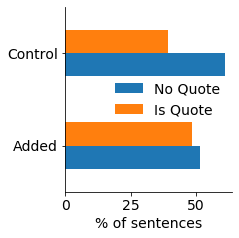

In [179]:
comb_df = pd.concat([
    contains_quote.value_counts().pipe(lambda s: s/s.sum()).to_frame('Added'),
    non_added_contains_quote.value_counts().pipe(lambda s: s/s.sum()).to_frame('Control')
], axis=1).rename(index={False: 'No Quote', True: 'Contains Quote'}) * 100

ax = comb_df.T.plot(kind='barh', figsize=(3,3.4))
plt.legend(['No Quote', 'Is Quote',], frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('% of sentences')

In [183]:
comb_df.round(2).loc[['Contains Quote', 'No Quote']].T

,Contains Quote,No Quote
Added,48.38,51.62
Control,39.22,60.78


### Contributor Lines

In [19]:
reporting_by = all_added_sents_df['sentence'].loc[lambda s: s.str.contains('reporting by')]
add_reporting = all_added_sents_df['sentence'].loc[lambda s: s.str.contains('additional reporting')]
contr_report = all_added_sents_df['sentence'].loc[lambda s: s.str.contains('contributed reporting')]
editing = all_added_sents_df['sentence'].loc[lambda s: s.str.contains('editing by')]

In [39]:
t = pd.concat([reporting_by, add_reporting, contr_report, editing]).drop_duplicates()

In [46]:
t.iloc[45]

'Additional reporting by Daniel Strauss in Richmond, Virginia, Richard Luscombe in West Palm Beach, Florida, and Ed Pilkington in Essex Junction, Vermont'

# Headline Changes

In [277]:
glob.glob('../data/diffengine-diffs/db/*')
to_run = [
#  '../data/diffengine-diffs/db/cnn.db.gz',
#  '../data/diffengine-diffs/db/nationalpost.db.gz',
#  '../data/diffengine-diffs/db/calgaryherald.db.gz',
#  '../data/diffengine-diffs/db/globemail.db.gz',
#  '../data/diffengine-diffs/db/torontostar.db.gz',
 '../data/diffengine-diffs/db/ap.db.gz',
#  '../data/diffengine-diffs/db/dailymail.db.gz',
#  '../data/diffengine-diffs/db/therebel.db.gz',
 '../data/diffengine-diffs/db/newssniffer-washpo.db',
 '../data/diffengine-diffs/db/newssniffer-guardian.db.gz',
#  '../data/diffengine-diffs/db/telegraph.db.gz',
 '../data/diffengine-diffs/db/reuters.db.gz',
#  '../data/diffengine-diffs/db/torontosun.db.gz',
 '../data/diffengine-diffs/db/newssniffer-independent.db.gz',
#  '../data/diffengine-diffs/db/bbc.db.gz',
#  '../data/diffengine-diffs/db/cbc.db.gz',
 '../data/diffengine-diffs/db/newssniffer-nytimes.db',
#  '../data/diffengine-diffs/db/canadaland.db.gz',
 '../data/diffengine-diffs/db/newssniffer-bbc.db.gz',
#  '../data/diffengine-diffs/db/fox.db.gz',
#  '../data/diffengine-diffs/db/lapresse.db.gz'
]

In [278]:
all_headline_match_dfs = []
for f in to_run:
    print(f)
    if f.endswith('.gz'):
        ! gunzip $f
    f = f.replace('.gz', '')
    conn = sqlite3.connect(f)
    match_df = pd.read_sql('''
        with c1 as (
            SELECT entry_id, version, title FROM entryversion
        )
            select 
                c1.entry_id as entry_id, 
                c1.version as version_x,
                c1.title = c2.title as headlines_match
                from c1
            join c1 as c2 on c1.entry_id = c2.entry_id AND c1.version + 1 = c2.version
    ''', con=conn)
    all_headline_match_dfs.append(match_df)
    ! gzip $f

../data/diffengine-diffs/db/ap.db.gz
../data/diffengine-diffs/db/newssniffer-washpo.db
../data/diffengine-diffs/db/newssniffer-guardian.db.gz
../data/diffengine-diffs/db/reuters.db.gz
../data/diffengine-diffs/db/newssniffer-independent.db.gz
../data/diffengine-diffs/db/newssniffer-nytimes.db
../data/diffengine-diffs/db/newssniffer-bbc.db.gz


In [279]:
headline_match_df_all = pd.concat(all_headline_match_dfs)

In [290]:
headline_match_df_all['headlines_match'].value_counts()

1.0    1826609
0.0     376944
Name: headlines_match, dtype: int64

In [291]:
headline_match_df_all['headlines_match'].value_counts().pipe(lambda s: s/s.sum())

1.0    0.828938
0.0    0.171062
Name: headlines_match, dtype: float64

In [292]:
headline_match_df_all['version_bins']

,entry_id,version_x,headlines_match
0,1,0.0,1.0
1,2,0.0,1.0
2,3,0.0,1.0
3,4,0.0,1.0
4,5,0.0,1.0
...,...,...,...
936767,2023662,0.0,1.0
936768,2023662,1.0,0.0
936769,2023672,0.0,0.0
936770,2023684,0.0,0.0


In [298]:
headline_match_df_all['version_bins'] = headline_match_df_all['version_x'].pipe(lambda s: pd.cut(s, [-1, 0, 1, 2, 4, 8, 16,32, 64], right=False))

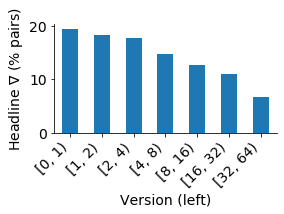

In [323]:
ax = (headline_match_df_all
      .groupby('version_bins')['headlines_match']
      .mean()
      .dropna()
      .pipe(lambda s: 1-s)
      .pipe(lambda s: s * 100)
      .plot(kind='bar', figsize=(4,2))
     )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Headline $\\nabla$ (% pairs)')
plt.xticks(rotation=45, horizontalalignment='right')
plt.xlabel('Version (left)')
plt.savefig('../presentations/acl2022/figures/headline-changes-by-version.pdf', bbox_inches='tight')

# Dist over versions

In [1]:
import glob
import pandas as pd 
import sqlite3

In [2]:
glob.glob('../data/diffengine-diffs/db/*')
to_run = [
#  '../data/diffengine-diffs/db/cnn.db.gz',
 '../data/diffengine-diffs/db/nationalpost.db.gz',
 '../data/diffengine-diffs/db/calgaryherald.db.gz',
 '../data/diffengine-diffs/db/globemail.db.gz',
 '../data/diffengine-diffs/db/torontostar.db.gz',
 '../data/diffengine-diffs/db/ap.db.gz',
 '../data/diffengine-diffs/db/dailymail.db.gz',
 '../data/diffengine-diffs/db/therebel.db.gz',
 '../data/diffengine-diffs/db/newssniffer-washpo.db.gz',
 '../data/diffengine-diffs/db/newssniffer-guardian.db.gz',
 '../data/diffengine-diffs/db/telegraph.db.gz',
 '../data/diffengine-diffs/db/reuters.db.gz',
 '../data/diffengine-diffs/db/torontosun.db.gz',
 '../data/diffengine-diffs/db/newssniffer-independent.db.gz',
#  '../data/diffengine-diffs/db/bbc.db.gz',
 '../data/diffengine-diffs/db/cbc.db.gz',
 '../data/diffengine-diffs/db/newssniffer-nytimes.db.gz',
 '../data/diffengine-diffs/db/canadaland.db.gz',
 '../data/diffengine-diffs/db/newssniffer-bbc.db.gz',
 '../data/diffengine-diffs/db/fox.db.gz',
 '../data/diffengine-diffs/db/lapresse.db.gz'
]

In [358]:
import os 
version_counts = []
for f in to_run:
    print(f)
    if f.endswith('.gz') and not os.path.exists(f.replace('gz', '')):
        ! gunzip -f $f
    f = f.replace('.gz', '')
    source = f.split('/')[-1].split('-')[-1].replace('.db', '')
    conn = sqlite3.connect(f)
    try:
        v_df = pd.read_sql('''
            with c1 as (
                SELECT DISTINCT entry_id, num_versions from entryversion
            )
            SELECT num_versions as max_version, count(1) as c 
                FROM c1
                GROUP BY num_versions
        ''', con=conn)
        v_df['source'] = source
        version_counts.append(v_df)
    except:
        pass
    ! gzip $f

../data/diffengine-diffs/db/nationalpost.db.gz
../data/diffengine-diffs/db/calgaryherald.db.gz
../data/diffengine-diffs/db/globemail.db.gz
../data/diffengine-diffs/db/torontostar.db.gz
../data/diffengine-diffs/db/ap.db.gz
../data/diffengine-diffs/db/dailymail.db.gz
../data/diffengine-diffs/db/therebel.db.gz
../data/diffengine-diffs/db/newssniffer-washpo.db.gz
../data/diffengine-diffs/db/newssniffer-guardian.db.gz
../data/diffengine-diffs/db/telegraph.db.gz
../data/diffengine-diffs/db/reuters.db.gz
gunzip: can't stat: ../data/diffengine-diffs/db/reuters.db.gz (../data/diffengine-diffs/db/reuters.db.gz.gz): No such file or directory
../data/diffengine-diffs/db/torontosun.db.gz
../data/diffengine-diffs/db/newssniffer-independent.db.gz
gunzip: can't stat: ../data/diffengine-diffs/db/newssniffer-independent.db.gz (../data/diffengine-diffs/db/newssniffer-independent.db.gz.gz): No such file or directory
../data/diffengine-diffs/db/cbc.db.gz
../data/diffengine-diffs/db/newssniffer-nytimes.db.g

In [359]:
version_counts_all = pd.concat(version_counts)

In [360]:
version_counts_all.to_csv('cache/max_version_counts_by_source.csv')

In [126]:
import numpy as np
import pandas as pd 

In [129]:
version_counts_all = pd.read_csv('cache/max_version_counts_by_source.csv', index_col=0)

In [152]:
version_counts_all['c'].sum()

1177438

In [132]:
max_versions = []
sources = []

for max_version, c, source in version_counts_all.itertuples(index=False):
    max_versions.extend([max_version] * c)
    sources.extend([source] * c)

expanded_versions_df = pd.DataFrame({'max_version': max_versions, 'source': sources})

In [136]:
expanded_versions_df['max_version'].mean()

3.7405553413428136

In [425]:
source_ord = (expanded_versions_df
 .groupby('source')['max_version']
 .quantile(.75)
 .sort_values(ascending=False)
 .index
)
source_map = {v:k for k,v in enumerate(source_ord)}

In [429]:
expanded_versions_df_sorted = expanded_versions_df.assign(order=lambda df: df['source'].map(source_map)).sort_values('order')

In [442]:
ls ../presentations/acl2022/

README.md        acl_natbib.bst   main.bbl         main.synctex.gz
acl.sty          anthology.bib    main.blg         main.tex
acl2021.bib      custom.bib       main.log         nert.sty
acl2021.sty      figures/         main.out
acl2021.tex      main.aux         main.pdf


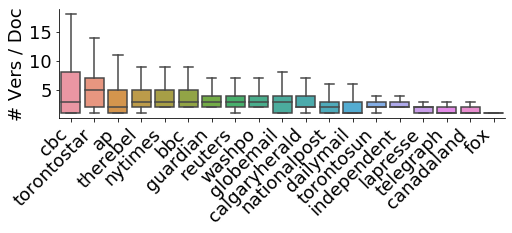

In [443]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=18)

f, ax = plt.subplots(1, 1, figsize=(8, 2))
ax = sns.boxplot(data=expanded_versions_df_sorted, y='max_version', x='source', showfliers=False, ax=ax)
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylabel('# Vers / Doc')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('')
plt.savefig('../presentations/acl2022/figures/boxplot-versions-per-source.pdf', bbox_inches='tight')

In [3]:
import os 
dt_counts = []
for f in to_run:
    print(f)
    if f.endswith('.gz') and not os.path.exists(f.replace('gz', '')):
        ! gunzip -f $f
    f = f.replace('.gz', '')
    source = f.split('/')[-1].split('-')[-1].replace('.db', '')
    conn = sqlite3.connect(f)

    update_times = pd.read_sql('''
        WITH c1 as ( 
            SELECT 
                entry_id, version, JULIANDAY(DATETIME(created)) AS dt 
            FROM entryversion 
            WHERE num_versions < 40
        ), c2 as (
            SELECT
                e1.entry_id as entry_id, 
                e1.version as version_x, 
                e2.version as version_y,
                e1.dt as dt_x,
                e2.dt as dt_y
            FROM c1 e1
            JOIN c1 e2 on e1.entry_id = e2.entry_id AND e1.version + 1 = e2.version
        )
        SELECT dt_y - dt_x as DAYS from c2
    ''', con=conn)
    update_times['source'] = source
    dt_counts.append(update_times)
    ! gzip $f

../data/diffengine-diffs/db/nationalpost.db.gz
../data/diffengine-diffs/db/calgaryherald.db.gz
../data/diffengine-diffs/db/globemail.db.gz
../data/diffengine-diffs/db/torontostar.db.gz
../data/diffengine-diffs/db/ap.db.gz
../data/diffengine-diffs/db/dailymail.db.gz
../data/diffengine-diffs/db/therebel.db.gz
../data/diffengine-diffs/db/newssniffer-washpo.db.gz
../data/diffengine-diffs/db/newssniffer-guardian.db.gz
gunzip: can't stat: ../data/diffengine-diffs/db/newssniffer-guardian.db.gz (../data/diffengine-diffs/db/newssniffer-guardian.db.gz.gz): No such file or directory
../data/diffengine-diffs/db/telegraph.db.gz
../data/diffengine-diffs/db/reuters.db.gz
../data/diffengine-diffs/db/torontosun.db.gz
../data/diffengine-diffs/db/newssniffer-independent.db.gz
../data/diffengine-diffs/db/cbc.db.gz
../data/diffengine-diffs/db/newssniffer-nytimes.db.gz
../data/diffengine-diffs/db/canadaland.db.gz
../data/diffengine-diffs/db/newssniffer-bbc.db.gz
../data/diffengine-diffs/db/fox.db.gz
../data

In [6]:
dt_counts_all = pd.concat(dt_counts)

In [54]:
dt_counts_grouped = dt_counts_all.groupby('source').quantile(.75).sort_values('DAYS', ascending=False)

In [55]:
dt_counts_grouped_75 = dt_counts_all.groupby('source').quantile(.75).sort_values('DAYS', ascending=False)
dt_mapper = {v:k for k,v in enumerate(dt_counts_grouped_75.index)}

In [56]:
dt_counts_all = dt_counts_all.assign(order=lambda df: df['source'].map(dt_mapper)).sort_values('order')

In [110]:
split_1 = 5
split_2 = 10
split_3 = 14
group_1 = dt_counts_grouped.iloc[:split_1]
group_2 = dt_counts_grouped.iloc[split_1:split_2]
group_3 = dt_counts_grouped.iloc[split_2:split_3]
group_4 = dt_counts_grouped.iloc[split_3:]

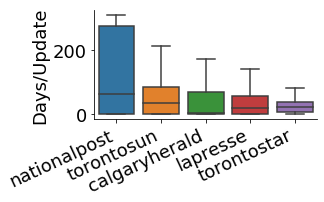

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=18)

f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax = sns.boxplot(
    data=dt_counts_all.loc[lambda df: df['source'].isin(group_1.index)].sort_values('order'), 
    y='DAYS',
    x='source',
    showfliers=False,
    ax=ax
)
plt.xticks(rotation=25, horizontalalignment='right')
plt.ylabel('Days/Update')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('')
plt.savefig('../presentations/acl2022/figures/time-delta-by-source-1.pdf', bbox_inches='tight')

In [112]:
import numpy as np 

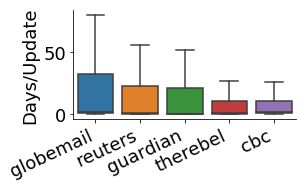

In [124]:
f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax = sns.boxplot(
    data=(dt_counts_all
         .loc[lambda df: df['source'].isin(group_2.index)]
         .sort_values('order')
#          .assign(DAYS=lambda df: np.log10(df['DAYS']).replace(-np.inf, 0).fillna(0))
        ),
    y='DAYS',
    x='source',
    showfliers=False,
    ax=ax
)

# from matplotlib import ticker as mticker
# ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
# ax.yaxis.set_ticks([np.log10(x) for p in range(-5,3) for x in np.linspace(10**p, 10**(p+1), 10)], minor=True)

plt.xticks(rotation=25, horizontalalignment='right')
plt.ylabel('Days/Update')
# plt.semilogy()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('')
plt.savefig('../presentations/acl2022/figures/time-delta-by-source-2.pdf', bbox_inches='tight')

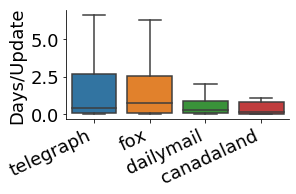

In [120]:
f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax = sns.boxplot(
    data=dt_counts_all.loc[lambda df: df['source'].isin(group_3.index)].sort_values('order'), 
    y='DAYS',
    x='source',
    showfliers=False,
    ax=ax
)
plt.xticks(rotation=25, horizontalalignment='right')
plt.ylabel('Days/Update')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('')
plt.savefig('../presentations/acl2022/figures/time-delta-by-source-3.pdf', bbox_inches='tight')

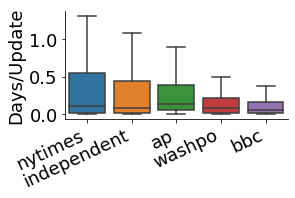

In [123]:
f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax = sns.boxplot(
    data=dt_counts_all.loc[lambda df: df['source'].isin(group_4.index)].sort_values('order'), 
    y='DAYS',
    x='source',
    showfliers=False,
    ax=ax
)
plt.xticks(rotation=25, horizontalalignment='right')
plt.ylabel('Days/Update')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('')
plt.savefig('../presentations/acl2022/figures/time-delta-by-source-4.pdf', bbox_inches='tight')

In [157]:
dt_counts_all.loc[lambda df: df['source'].isin(group_1.index)]['DAYS'].median()

21.749276620568708

In [158]:
dt_counts_all.loc[lambda df: df['source'].isin(group_2.index)]['DAYS'].median()

0.9421643521636724

In [162]:
dt_counts_all.loc[lambda df: df['source'].isin(group_3.index)]['DAYS'].median()

0.3502372682560235

In [160]:
dt_counts_all.loc[lambda df: df['source'].isin(group_3.index)]['DAYS'].median() * 24

8.405694438144565

In [163]:
dt_counts_all.loc[lambda df: df['source'].isin(group_4.index)]['DAYS'].median()

0.05555555550381541

In [161]:
dt_counts_all.loc[lambda df: df['source'].isin(group_4.index)]['DAYS'].median() * 24

1.33333333209157

In [7]:
v_counts = (version_counts_all
 .assign(version_bin=lambda df: pd.cut(df['version'], bins=[0,1,2,4,8,16,32,64,128,256,512,1024,2048], right=False))
).groupby('version_bin')['c'].sum()

In [8]:
v_counts

version_bin
[0, 1)          1177438
[1, 2)           958540
[2, 4)           905469
[4, 8)           602022
[8, 16)          321489
[16, 32)         205786
[32, 64)         105821
[64, 128)         43306
[128, 256)        29569
[256, 512)        29846
[512, 1024)       13630
[1024, 2048)        230
Name: c, dtype: int64

In [2]:
ls ../../controlled-sequence-gen/data/

corpus-webis-editorials-16-processed.csv
doc-edits-large__add-labels.tsv
doc-edits-large__deleted-labels.tsv.gz
doc-edits-large__edited-labels.tsv.gz
doc-edits-large__refactored-labels.tsv.gz
doc-edits__add-labels.tsv
doc-edits__deleted-labels.tsv
doc-edits__edited-labels.tsv
doc-edits__refactored-labels.tsv
finlayson-discourse-data.csv
news-discourse-high-level-labels-processed.tsv
news-discourse-processed.tsv
news-discourse-training-data.csv
pdtb-training-data.csv
rst-training-data.csv
semi-balanced-data-by-sentence.csv
semi-balanced-data-by-sentence.tsv
sentence-edits__add-labels.tsv
sentence-edits__operation-labels.tsv
sentence-edits__refactor-labels.tsv
spangher-discourse-data.csv
translated_labeled_articles__en-de.single_model.csv.gz
unlabeled_articles.csv
unlabeled_articles_processed.tsv


In [4]:
import pandas as pd 

In [24]:
adds = pd.read_csv('../../controlled-sequence-gen/data/doc-edits-large__add-labels.tsv', sep='\t', header=None)
dels = pd.read_csv('../../controlled-sequence-gen/data/doc-edits-large__deleted-labels.tsv.gz', sep='\t', header=None)
edits = pd.read_csv('../../controlled-sequence-gen/data/doc-edits-large__edited-labels.tsv.gz', sep='\t', header=None)
refs = pd.read_csv('../../controlled-sequence-gen/data/doc-edits-large__refactored-labels.tsv.gz', sep='\t', header=None)

In [25]:
multitask = adds.copy()
multitask[0] = adds[0] + '|||' + dels[0] + '|||' + edits[0] + '|||' + refs[0]

In [27]:
multitask.to_csv('../../controlled-sequence-gen/data/doc-edits-large__multitask.tsv.gz', sep='\t', header=False, index=False)

In [26]:
multitask[0][0]

'added: [1, 5)|||deleted: [3, 100)|||edited: [1, 3)|||refactored: (-100, -1]'

In [139]:
training_data = pd.read_csv('../modeling/data/training_data_full.csv.gz')

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [143]:
training_data['entry_id'].drop_duplicates().shape

(302641,)

In [150]:
t = (training_data
 [['deleted_label', 'add_above_label', 'add_below_label', 'edited_label', 'unchanged_label', 'refactored_label']]
 .fillna(0)
 .assign(refactored_label=lambda df: (df['refactored_label'] != 0).astype(int))
 .sum()
)

In [151]:
t

deleted_label         937063.0
add_above_label      1427850.0
add_below_label      1631487.0
edited_label         2379602.0
unchanged_label     10291433.0
refactored_label      111383.0
dtype: float64

In [154]:
(4_600_000 / 302_641) * t

deleted_label       1.424291e+07
add_above_label     2.170264e+07
add_below_label     2.479783e+07
edited_label        3.616882e+07
unchanged_label     1.564249e+08
refactored_label    1.692969e+06
dtype: float64

# Make Data for Version Task

In [1]:
import glob
import sqlite3
import pandas as pd 

In [2]:
ls ../data/diffengine-diffs/spark-output/

ap-matched-sentences.db.gz           nyt-matched-sentences.db.gz
bbc-2-matched-sentences.db.gz        reuters-matched-sentences.db.gz
guardian-matched-sentences.db.gz     wp-matched-sentences.db.gz
independent-matched-sentences.db.gz


In [311]:
glob.glob('../data/diffengine-diffs/db/*')
to_run = [
#  '../data/diffengine-diffs/db/nationalpost.db.gz',
#  '../data/diffengine-diffs/db/calgaryherald.db.gz',
#  '../data/diffengine-diffs/db/globemail.db.gz',
#  '../data/diffengine-diffs/db/torontostar.db.gz',
 '../data/diffengine-diffs/db/ap.db.gz',
#  '../data/diffengine-diffs/db/dailymail.db.gz',
#  '../data/diffengine-diffs/db/therebel.db.gz',
 '../data/diffengine-diffs/db/newssniffer-washpo.db.gz',
 '../data/diffengine-diffs/db/newssniffer-guardian.db.gz',
#  '../data/diffengine-diffs/db/telegraph.db.gz',
 '../data/diffengine-diffs/db/reuters.db.gz',
#  '../data/diffengine-diffs/db/torontosun.db.gz',
 '../data/diffengine-diffs/db/newssniffer-independent.db.gz',
#  '../data/diffengine-diffs/db/bbc.db.gz',
#  '../data/diffengine-diffs/db/cbc.db.gz',
 '../data/diffengine-diffs/db/newssniffer-nytimes.db.gz',
#  '../data/diffengine-diffs/db/canadaland.db.gz',
 '../data/diffengine-diffs/db/newssniffer-bbc.db.gz',
#  '../data/diffengine-diffs/db/fox.db.gz',
#  '../data/diffengine-diffs/db/lapresse.db.gz'
]

In [6]:
import os 
all_version_info = []
for f in to_run:
    print(f)
    if f.endswith('.gz') and not os.path.exists(f.replace('gz', '')):
        ! gunzip -f $f
    f = f.replace('.gz', '')
    source = f.split('/')[-1].split('-')[-1].replace('.db', '')
    conn = sqlite3.connect(f)
    vers_info_df = pd.read_sql('''
        SELECT entry_id, LENGTH(summary) as doc_len, num_versions, version FROM entryversion
        WHERE num_versions < 40
        AND doc_len < 2000
    ''', con=conn)
    vers_info_df['source'] = source
    all_version_info.append(vers_info_df)
    ! gzip $f

../data/diffengine-diffs/db/ap.db.gz
../data/diffengine-diffs/db/newssniffer-washpo.db.gz
../data/diffengine-diffs/db/newssniffer-guardian.db.gz
../data/diffengine-diffs/db/reuters.db.gz
../data/diffengine-diffs/db/newssniffer-independent.db.gz
../data/diffengine-diffs/db/newssniffer-nytimes.db.gz
../data/diffengine-diffs/db/newssniffer-bbc.db.gz


In [7]:
all_version_info_df = pd.concat(all_version_info)

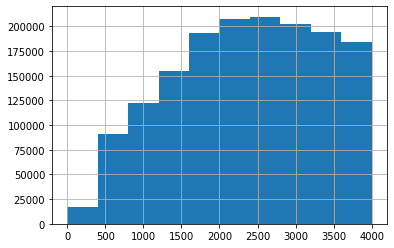

In [36]:
all_version_info_df['doc_len'].hist(range=(0, 4000))

In [42]:
source_weights = (
    25000 * 1 / all_version_info_df.loc[lambda df: df['doc_len'] < 4000]['source'].value_counts()
)

In [21]:
(all_version_info_df['version'] == all_version_info_df['num_versions']-1).value_counts()

False    2147745
True      749280
dtype: int64

In [23]:
earlier_training_data = pd.read_csv('../modeling/data/training_data_full.csv.gz')

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [28]:
earlier_training_data = earlier_training_data.loc[lambda df: df['sentence'].notnull()]

In [29]:
t = earlier_training_data.groupby(['source','entry_id', 'version'])['sentence'].aggregate(list)

In [31]:
s = t.apply(lambda x: ' '.join(x).strip())

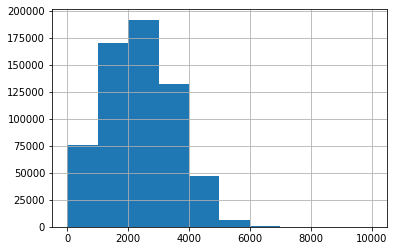

In [35]:
s.str.len().hist(range=(0, 10000))

In [312]:
import os 
all_version_info_w_summ = []
for f in to_run:
    print(f)
    if f.endswith('.gz') and not os.path.exists(f.replace('gz', '')):
        ! gunzip -f $f
    f = f.replace('.gz', '')
    source = f.split('/')[-1].split('-')[-1].replace('.db', '')
    conn = sqlite3.connect(f)
    vers_info_df = pd.read_sql('''
        SELECT * FROM entryversion WHERE entry_id IN (
            SELECT entry_id 
                FROM entryversion 
                WHERE num_versions < 40 AND LENGTH(summary) > 1000 AND LENGTH(summary) < 4000
          ORDER BY RANDOM() LIMIT 30000
        )
    ''', con=conn)
    vers_info_df['source'] = source
    all_version_info_w_summ.append(vers_info_df)
    ! gzip $f

../data/diffengine-diffs/db/ap.db.gz
../data/diffengine-diffs/db/newssniffer-washpo.db.gz
../data/diffengine-diffs/db/newssniffer-guardian.db.gz
../data/diffengine-diffs/db/reuters.db.gz
../data/diffengine-diffs/db/newssniffer-independent.db.gz
../data/diffengine-diffs/db/newssniffer-nytimes.db.gz
../data/diffengine-diffs/db/newssniffer-bbc.db.gz


In [313]:
all_version_info_w_summ_df = pd.concat(all_version_info_w_summ)

- balanced for length, version_x
- equal numbers: is_updated=1, is_updated=0

In [314]:
all_version_info_w_summ_df['doc_len'] = all_version_info_w_summ_df['summary'].str.len()
all_version_info_w_summ_df = (
    all_version_info_w_summ_df
    .loc[lambda df: df['doc_len'] > 1400]
#     .loc[lambda df: df['doc_len'] < 3500]
)

In [322]:
all_version_info_w_summ_df['label'] = (
    all_version_info_w_summ_df.pipe(lambda df: df['version'] == df['num_versions']-1)
)

label_w = 10000* 1/all_version_info_w_summ_df['label'].value_counts()

all_version_info_w_summ_df_lab = all_version_info_w_summ_df.merge(
    label_w.to_frame('label_w'),
    right_index=True,
    left_on=['label']
)

b_lab__all_version_info_w_summ_df_lab = (
    all_version_info_w_summ_df_lab.pipe(lambda df: df.sample(200_000, weights=df['label_w']))
)

In [323]:
b_lab__all_version_info_w_summ_df_lab['label'].value_counts()

False    117220
True      82780
Name: label, dtype: int64

In [324]:
b_lab__all_version_info_w_summ_df_lab['version_bin'] = pd.cut(
    b_lab__all_version_info_w_summ_df_lab['version'], 
    bins=[0,1,2,4,8,16,32,64], 
    right=False
)
v_bin_weights = (
    b_lab__all_version_info_w_summ_df_lab['version_bin']
    .value_counts()
    .sort_index()
)

b_lab__all_version_info_w_summ_df_lab = (
    b_lab__all_version_info_w_summ_df_lab
        .merge(
            (30000 * (1 / v_bin_weights)).to_frame('v_bin_w'),
            left_on=['version_bin'],
            right_index=True
        )
)

In [325]:
b_lab__all_version_info_w_summ_df_lab['label'].value_counts()

False    117220
True      82780
Name: label, dtype: int64

In [328]:
b_all_version_df = b_lab__all_version_info_w_summ_df_lab.pipe(lambda df: df.sample(130_000, weights=df['v_bin_w']))

In [329]:
b_all_version_df['label'].value_counts()

False    78728
True     51272
Name: label, dtype: int64

In [330]:
b_all_version_df['len_bin'] = (
    b_all_version_df
    .pipe(lambda df: pd.cut(df['doc_len'], range(-200,4000,200), right=False))
)

In [331]:
sources = b_all_version_df['source'].unique()
source_name_map = {
    'washpo':'wp'
}

all_found = []
for source in sources:
    print(source)
    sampled_docs = b_all_version_df.loc[lambda df: df['source'] == source]
    # get sents 
    sname = source_name_map.get(source, source)
    cached_sent_files = glob.glob('cache/%s-sents__*.pkl' % sname)
    for f in cached_sent_files:
        cached_sents = pd.read_pickle(f)

        sents = (sampled_docs[['entry_id', 'version']]
         .merge(cached_sents, left_on=['entry_id', 'version'], right_on=['entry_id', 'version'])
         .groupby(['entry_id', 'version'])
         .apply(lambda df: '<SENT>'.join(df.sort_values('sent_idx')['sentence'].tolist()))
        )
        finished = (sampled_docs
         .merge(sents.to_frame('sentences'), left_on=['entry_id','version'], right_on=['entry_id', 'version'])
        )
        print(finished.shape)
        all_found.append(finished)

bbc
(5098, 19)
(5761, 19)
(811, 19)
(7243, 19)
nytimes
ap
(9505, 19)
reuters
(15608, 19)
washpo
(6587, 19)
guardian
(3603, 19)
(3874, 19)
(3531, 19)
(4792, 19)
(2223, 19)
(3993, 19)
(3706, 19)
independent
(15951, 19)


In [332]:
b_all_version_df.shape

(130000, 18)

In [333]:
all_found_df = pd.concat(all_found)

In [334]:
mapper ={True: 'Last Version', False:'Not Last Version'}

In [335]:
all_found_df['label'] = (all_found_df['version'] == (all_found_df['num_versions']-1)).apply(lambda x: mapper[x])

In [350]:
v = (
    all_found_df
        .assign(key=lambda df: df[['source', 'entry_id', 'version']].apply(lambda x: '%s-%s-%s' % tuple(x), axis=1))
        .assign(sent_idx=0)
        [['label', 'sentences', 'key', 'sent_idx']]
)

(v
        .loc[lambda df: df['sentences'].str.len() < 6_000]
        .to_csv('../../controlled-sequence-gen/data/version-edits__10k.tsv', sep='\t', header=None, index=False)
)

In [349]:
v.loc[lambda df: df['sentences'].str.len() < 6_000]['sentences'].str.len().describe()

count    87708.000000
mean      3056.664478
std        992.601989
min       1255.000000
25%       2284.000000
50%       2977.000000
75%       3695.000000
max       5999.000000
Name: sentences, dtype: float64

In [178]:
v = pd.read_csv('../../controlled-sequence-gen/data/version-edits__100k.tsv', sep='\t', header=None)

In [187]:
t = v[[0, 2]].assign(v=lambda df: df[2].str.split('-').str.get(2).astype(float).astype(int))

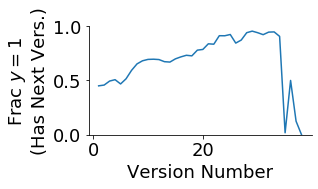

In [209]:
ax = (t.groupby('v')[0]
 .value_counts()
 .unstack()
 .sort_index()
 .fillna(0)
 .pipe(lambda df: df['Not Last Version'] / df.sum(axis=1))
 .iloc[1:]
 .plot(figsize=(4,2))
)
plt.ylim((0,1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Frac $y=1$\n(Has Next Vers.)')
plt.xlabel('Version Number')
plt.savefig('../presentations/acl2022/figures/training-data-version.pdf', bbox_inches='tight')

In [299]:
sample_to_annotate = (all_found_df
 [['source', 'entry_id', 'version', 'title', 'summary', 'doc_len']]
 .loc[lambda df: df['doc_len'] < 2000]
 .sample(150)
 .drop('doc_len', axis=1)
 .assign(summary=lambda df: df['summary'].str.replace('<p>', '').str.replace('</p>', '').str.strip())
 .assign(version=lambda df: df['version'].astype(int))
 .rename(columns={'title': 'headline', 'summary': 'article'})
 .reset_index(drop=True)
)

In [300]:
sample_to_annotate.head(5)

,source,entry_id,version,headline,article
0,bbc,634076,1,HIV spread in England 'could be halted within ...,The spread of HIV in England can be stopped wi...
1,independent,1412523,3,Manchester airport terminal 3 evacuated after ...,Manchester Airport's terminal three has been e...
2,bbc,724690,1,Infosys raises sales outlook as it reports ear...,Infosys has raised its full-year sales outlook...
3,guardian,612172,2,British schoolgirl dies after chairlift fall i...,A 13-year-old girl from Kent has died after fa...
4,bbc,589093,3,Great Ormond Street Hospital Christmas present...,Christmas presents for children in an intensiv...


In [301]:
ls ../evaluation/data

data-downsampled.json               sample_datum_corrections.json
output_data/                        sample_datum_many.json
sample_ap_data.json                 sample_datum_many_sent_breaks.json
sample_datum.json


In [302]:
sample_to_annotate.to_csv('../evaluation/data/version-data-to-annotate.csv', index=False)

In [307]:
import pyperclip

In [310]:
(sample_to_annotate
 .merge(
     all_found_df[['source', 'entry_id', 'version', 'label']], 
     right_on=['source', 'entry_id', 'version'],
     left_on=['source', 'entry_id', 'version']
).to_csv('tmp/tmp.csv')
)

In [183]:
b_all_version_df['summary']

114598    A direct appeal has been made to man who is th...
112785    By Marc Settle BBC Radio 4's Broadcasting Hous...
74098     Commons Speaker Michael Martin is to hold a co...
5927      <p> SEOUL, South Korea (AP) -- As Malaysian po...
1205      Iron Maiden singer Bruce Dickinson is hoping t...
                                ...                        
99062     Labor has claimed victory in the byelection fo...
27237     <p> SAN DIEGO (AP) -- A Sinaloa cartel leader ...
537       David Cameron called for sanctions against Bur...
13604     <p> WASHINGTON (AP) -- Leaders of a House inve...
18465     EILEAN IARMAIN, ISLE OF SKYE, SCOTLAND — The c...
Name: summary, Length: 100000, dtype: object

In [174]:
training_df = pd.read_csv('../modeling/data/training_data_full.csv.gz')

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [179]:
s_we_have = training_df[['source', 'entry_id']].drop_duplicates()

In [181]:
b_all_version_df[['source', 'entry_id']].merge(s_we_have, right_on=['source','entry_id'], left_on=['source', 'entry_id'])

,source,entry_id
0,bbc,257702
1,bbc,257702
2,bbc,257702
3,bbc,257702
4,bbc,257702
...,...,...
57264,independent,1418412
57265,ap,15584
57266,guardian,616077
57267,guardian,512924


# Parallelize tokenize

In [ ]:
import spacy
import re
from tqdm.auto import tqdm

from joblib import Parallel, delayed

def chunker(df_iterable, total_length, chunksize):
    return (df_iterable.iloc[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

def preprocess_parallel(df, func, chunksize=100):
    executor = Parallel(n_jobs=11, backend='multiprocessing', prefer="processes")
    do = delayed(func)
    tasks = (do(chunk) for chunk in tqdm(chunker(df, len(df), chunksize=chunksize)))
    result = executor(tasks)
    return flatten(result)

nlp = spacy.load('en_core_web_sm', disable=['tagger', 'ner'])
def get_sentences_col(df_chunk):
    return handle_spacy_chunk(df_chunk, get_sentences_pipe)


def get_sentences_pipe(par_doc, entry_id, version, p_idx, s_idx_start=0):
    output = []
    sents = list(map(lambda s: s.text, par_doc.sents))
    sents = list(map(lambda s: ' '.join(s.split()), sents))
    for s_idx, s in enumerate(sents):
        output.append({
            'par_idx': p_idx,
            'sentence': s,
            'sent_idx': s_idx_start + s_idx,
            'entry_id': entry_id,
            'version': version
        })
    return output

def handle_spacy_chunk(df_chunk, processor_function):
    docs, entry_ids, versions = (
        df_chunk['summary'].tolist(), 
        df_chunk['entry_id'].tolist(), 
        df_chunk['version'].tolist()
    )
    output_sentences = []
    all_pars = []
    all_par_ids = []
    all_entry_ids = []
    all_versions = []
    # prepare
    for entry_id, version, doc in zip(entry_ids, versions, docs):
        pars = re.split('</p>\s*<p>', doc)
        p_idxes = list(range(len(pars)))
        all_pars.extend(pars)
        all_par_ids.extend(p_idxes)
        all_entry_ids.extend([entry_id] * len(pars))
        all_versions.extend([version] * len(pars))

    # index
    prev_entry_id = entry_ids[0]
    prev_version = versions[0]
    curr_sentences = []
    for i, par_doc in enumerate(nlp.pipe(all_pars, batch_size=20)):
        curr_par_id = all_par_ids[i]
        curr_entry_id = all_entry_ids[i]
        curr_version = all_versions[i]
        if (curr_entry_id == prev_entry_id) and (curr_version == prev_version):
            starting_sent_idx = len(curr_sentences)
        else:
            starting_sent_idx = 0
            output_sentences.extend(curr_sentences)
            curr_sentences = []
        curr_sentences.extend(
            processor_function(par_doc, curr_entry_id, curr_version, curr_par_id, s_idx_start=starting_sent_idx)
        )
        prev_entry_id = curr_entry_id
        prev_version = curr_version

    output_sentences.extend(curr_sentences)
    return output_sentences


sentences = preprocess_parallel(b_all_version_df, get_sentences_col, chunksize=40)

In [164]:
t = {'device_A': ['192.168.1.1/24', '192.168.1.2/24', '192.168.1.3/24'],
'device_B': ['192.168.1.1/24', '192.168.1.20/24', '192.168.1.21/24'],
'device_C': ['192.168.1.21/24', '192.168.1.30/24']}

In [165]:
import itertools

In [172]:
itertools.combinations()

itertools.combinations

In [173]:
list(itertools.product(t.items(), t.items()))

for (k_i, v_i), (k_j, v_j) in itertools.combinations(t.items(), 2):
    overlap = set(v_i) & set(v_j)
    if k_i != k_j:
        if len(overlap) > 0:
            print('overlapping items, from %s and %s: %s' % (k_i, k_j, str(overlap)))

overlapping items, from device_A and device_B: {'192.168.1.1/24'}
overlapping items, from device_B and device_C: {'192.168.1.21/24'}
